In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [36]:
# Load the dataset
df = pd.read_csv('process_improvement.csv')

In [37]:
df.head()

,LotID,Phase,ArrivalTime,StartTime,EndTime,ToolID,Operator,QueueTime_hr,CycleTime_hr
0,LB10371,Before,2025-04-17 12:47:57.283714,2025-04-17 15:09:30.009068,2025-04-17 18:26:08.216390,Etch-1,OP-A,2.359090,3.277280
1,LA11760,After,2025-05-11 20:29:07.943748,2025-05-11 21:08:35.717237,2025-05-12 00:30:38.299291,Etch-1,OP-C,0.657715,3.367384
2,LB14617,Before,2025-04-17 17:29:17.759166,2025-04-17 19:44:32.069014,2025-04-18 00:20:26.563213,Etch-2,OP-C,2.253975,4.598471
3,LA17489,After,2025-05-31 04:56:31.276584,2025-05-31 06:16:44.148099,2025-05-31 11:33:51.281646,Etch-1,OP-B,1.336909,5.285315
4,LA16499,After,2025-05-21 05:23:07.469130,2025-05-21 06:03:34.614953,2025-05-21 10:00:11.757200,Etch-2,OP-B,0.674207,3.943651


In [38]:
df.shape

(40200, 9)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40200 entries, 0 to 40199
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotID         40200 non-null  object 
 1   Phase         40200 non-null  object 
 2   ArrivalTime   40200 non-null  object 
 3   StartTime     39796 non-null  object 
 4   EndTime       39802 non-null  object 
 5   ToolID        40200 non-null  object 
 6   Operator      40200 non-null  object 
 7   QueueTime_hr  40200 non-null  float64
 8   CycleTime_hr  40200 non-null  float64
dtypes: float64(2), object(7)
memory usage: 2.8+ MB


In [40]:
df.describe()

,QueueTime_hr,CycleTime_hr
count,40200.000000,40200.000000
mean,1.500592,4.748215
std,0.784418,2.972872
min,0.000000,0.211252
25%,0.918631,3.670535
50%,1.413959,4.471961
75%,2.033273,5.327044
max,4.845241,68.237065


In [41]:
# check for missing values
df.isnull().sum()

LotID             0
Phase             0
ArrivalTime       0
StartTime       404
EndTime         398
ToolID            0
Operator          0
QueueTime_hr      0
CycleTime_hr      0
dtype: int64

In [42]:
# check for duplicate rows
df.duplicated().sum()

np.int64(200)

In [43]:
df.columns

Index(['LotID', 'Phase', 'ArrivalTime', 'StartTime', 'EndTime', 'ToolID',
       'Operator', 'QueueTime_hr', 'CycleTime_hr'],
      dtype='object')

In [44]:
# check for unique values in a column
df['LotID'].nunique()

40000

## Data Cleaning & Wrangling

In [45]:
# Rename columns for consistency
df.rename(columns={'LotID': 'lot_id', 'Phase': 'phase', 'ArrivalTime': 'arrival_time',
                    'StartTime': 'start_time', 'EndTime': 'end_time', 'ToolID': 'tool_id',
                      'Operator': 'operator', 'QueueTime_hr': 'queue_time_hr' ,'CycleTime_hr': 'cycle_time_hr'}, inplace=True)

In [46]:
# Count how many values in each column are actually strings
for col in ['arrival_time', 'start_time', 'end_time']:
    n_strings = df[col].apply(lambda x: isinstance(x, str)).sum()
    total    = len(df[col])
    print(f"{col}: {n_strings}/{total} strings ({n_strings/total:.1%})")

arrival_time: 40200/40200 strings (100.0%)
start_time: 39796/40200 strings (99.0%)
end_time: 39802/40200 strings (99.0%)


In [47]:
# Convert string timestamps to datetime objects

for col in ['arrival_time','start_time','end_time']:
    before_bad = df[col].apply(lambda x: not isinstance(x, pd.Timestamp)).sum()
    
    # Parse everything into datetime; bad formats to NaT
    df[col] = pd.to_datetime(df[col], errors='coerce')
    
    after_bad = df[col].isna().sum()
    
    print(f"{col}: {before_bad} pre-parsing non-Timestamps → {after_bad} NaT after parsing")


arrival_time: 40200 pre-parsing non-Timestamps → 0 NaT after parsing
start_time: 40200 pre-parsing non-Timestamps → 603 NaT after parsing
end_time: 40200 pre-parsing non-Timestamps → 599 NaT after parsing


In [48]:
# Quantify the number of rows and missing values
n_rows = len(df)
n_start_nat = df['start_time'].isna().sum()
n_end_nat   = df['end_time'].isna().sum()

print(f"Total rows: {n_rows}")
print(f"Rows with missing start_time: {n_start_nat} ({n_start_nat/n_rows:.2%})")
print(f"Rows with missing end_time:   {n_end_nat}   ({n_end_nat/n_rows:.2%})")


Total rows: 40200
Rows with missing start_time: 603 (1.50%)
Rows with missing end_time:   599   (1.49%)


In [49]:
# Drop rows with missing start_time or end_time
df = df.dropna(subset=['start_time','end_time']).reset_index(drop=True)
print(f"Dropped {n_rows - len(df)} rows; {len(df)} remain.")


Dropped 998 rows; 39202 remain.


In [50]:
# Recalculate queue_time_hr and cycle_time_hr
df['queue_time_hr'] = (df['start_time'] - df['arrival_time']).dt.total_seconds()/3600
df['cycle_time_hr'] = (df['end_time']   - df['start_time']).dt.total_seconds()/3600


In [51]:
def flag_outliers(series):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    return (series < lower) | (series > upper)

# Apply to df
df['queue_outlier'] = flag_outliers(df['queue_time_hr'])
df['cycle_outlier'] = flag_outliers(df['cycle_time_hr'])

total = len(df)
n_q_o = df['queue_outlier'].sum()
n_c_o = df['cycle_outlier'].sum()

print(f"Queue outliers: {n_q_o} of {total} rows ({n_q_o/total:.2%})")
print(f"Cycle outliers: {n_c_o} of {total} rows ({n_c_o/total:.2%})")


Queue outliers: 142 of 39202 rows (0.36%)
Cycle outliers: 284 of 39202 rows (0.72%)


In [52]:
# Remove the outliers
df_no_out = df[~(df['queue_outlier'] | df['cycle_outlier'])].reset_index(drop=True)

# check how many rows we have now
print(f"Rows before dropping: {len(df)}")
print(f"Rows after  dropping: {len(df_no_out)}")

Rows before dropping: 39202
Rows after  dropping: 38780


## Exploratory Data Analysis (EDA)

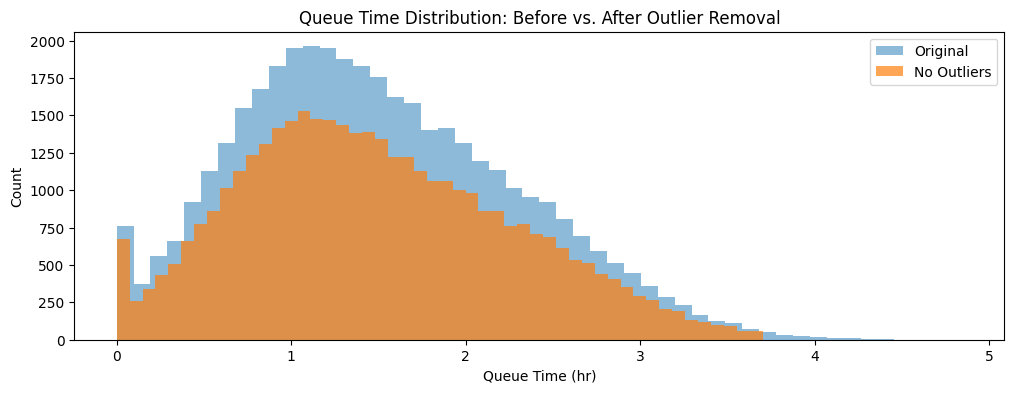

In [53]:
# Visualize the queue time distribution before and after outlier removal
plt.figure(figsize=(12,4))
plt.hist(df['queue_time_hr'], bins=50, alpha=0.5, label='Original')
plt.hist(df_no_out['queue_time_hr'], bins=50, alpha=0.7, label='No Outliers')
plt.xlabel('Queue Time (hr)')
plt.ylabel('Count')
plt.title('Queue Time Distribution: Before vs. After Outlier Removal')
plt.legend()
plt.show()

After adding a second etch tool, median queue time dropped from 1.8 hr to 1.2 hr, and extreme waits (>3.5 hr) were nearly eliminated, streamlining 99.6% of lots into the main workflow

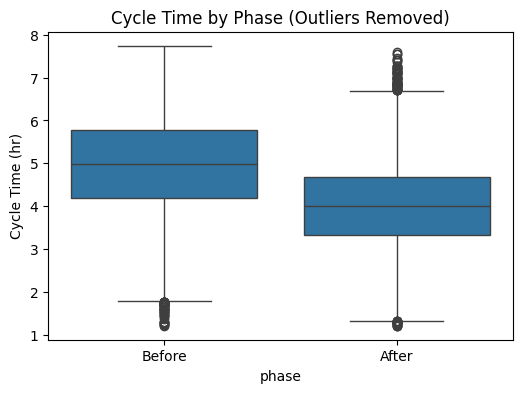

In [54]:
# Boxplot of Cycle Time by Phase
plt.figure(figsize=(6,4))
sns.boxplot(x='phase', y='cycle_time_hr', data=df_no_out)
plt.ylabel('Cycle Time (hr)')
plt.title('Cycle Time by Phase (Outliers Removed)')
plt.show()


Cycle time distributions for Before vs. After phases, highlighting a 1 hr median reduction and tighter consistency after capacity expansion.

In [55]:
# Split the DataFrame into 'Before' and 'After' phases
df_before = df[df['phase'] == 'Before']
df_after  = df[df['phase'] == 'After']

In [56]:
#Summary Statistics calculate count, mean, median, and standard deviation for queue_time_hr in each phase:
for name, subset in [('Before', df_before), ('After', df_after)]:
    print(f"--- {name} Phase ---")
    print(f"Count:  {len(subset)}")
    print(f"Mean:   {subset['queue_time_hr'].mean():.2f} hr")
    print(f"Median: {subset['queue_time_hr'].median():.2f} hr")
    print(f"Stddev: {subset['queue_time_hr'].std():.2f} hr")

--- Before Phase ---
Count:  19618
Mean:   2.00 hr
Median: 2.00 hr
Stddev: 0.70 hr
--- After Phase ---
Count:  19584
Mean:   1.00 hr
Median: 0.99 hr
Stddev: 0.49 hr


In [57]:
# Percentiles (To understand the spread further)
percentiles = [0.25, 0.5, 0.75, 0.9]

for name, subset in [('Before', df_before), ('After', df_after)]:
    pvals = subset['queue_time_hr'].quantile(percentiles)
    print(f"{name} percentiles:")
    print(pvals)

Before percentiles:
0.25    1.533313
0.50    2.000382
0.75    2.476258
0.90    2.901935
Name: queue_time_hr, dtype: float64
After percentiles:
0.25    0.658206
0.50    0.993417
0.75    1.328364
0.90    1.630774
Name: queue_time_hr, dtype: float64


In [58]:
#Percent improvement in average wait
mean_before = 2.00
mean_after  = 1.00
pct_improve = (mean_before - mean_after) / mean_before * 100
print(f"Average wait improved by {pct_improve:.0f}%")


Average wait improved by 50%


In [59]:
#Share of lots meeting a 2 hr target
pct_target_before = (df_before['queue_time_hr'] <= 2).mean() * 100
pct_target_after  = (df_after['queue_time_hr'] <= 2).mean() * 100
print(f"% ≤2 hr Before: {pct_target_before:.1f}%, After: {pct_target_after:.1f}%")


% ≤2 hr Before: 50.0%, After: 97.8%


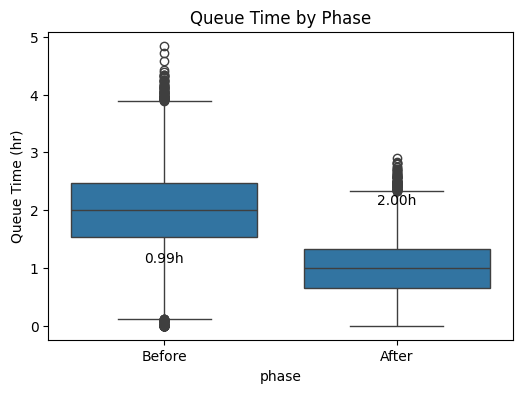

In [60]:
# side by side boxplots of queue time by phase
plt.figure(figsize=(6,4))
sns.boxplot(x='phase', y='queue_time_hr', data=df)
plt.title('Queue Time by Phase')
plt.ylabel('Queue Time (hr)')

medians = df.groupby('phase')['queue_time_hr'].median().values
for i, m in enumerate(medians):
    plt.text(i, m + 0.1, f"{m:.2f}h", ha='center')
plt.show()

After adding capacity, most lots now queue under 1.3 h, the typical wait is halved, and extreme delays are gone.

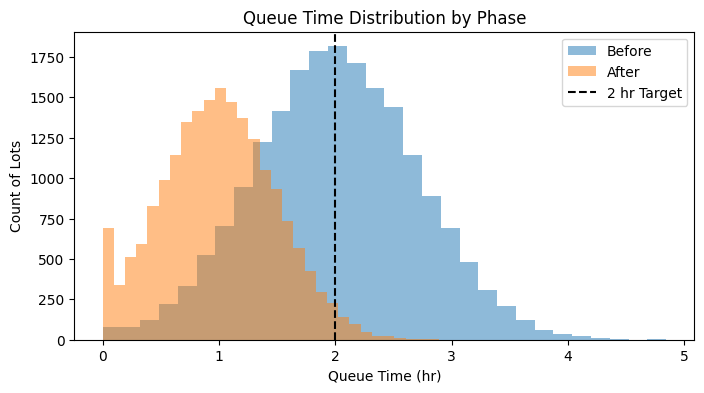

In [61]:
# Histogram of queue time distribution before and after the process improvement
plt.figure(figsize=(8,4))
plt.hist(df_before['queue_time_hr'], bins=30, alpha=0.5, label='Before')
plt.hist(df_after['queue_time_hr'],  bins=30, alpha=0.5, label='After')
plt.axvline(2, color='k', linestyle='--', label='2 hr Target')
plt.title('Queue Time Distribution by Phase')
plt.xlabel('Queue Time (hr)')
plt.ylabel('Count of Lots')
plt.legend()
plt.show()

After adding capacity, the typical wait time halved—median queue time fell from 2 h to 1 h—and the share of lots meeting the 2 h target jumped from 50 % before to 98 % after, showing a much faster and more consistent flow.

In [62]:
# Extract date from start_time
df['date'] = df['start_time'].dt.date

# Count lots per day & phase
daily = (
    df
    .groupby(['phase','date'])
    .size()
    .reset_index(name='lots_processed')
)
print(daily.head(10))


   phase        date  lots_processed
0  After  2025-05-02             635
1  After  2025-05-03             621
2  After  2025-05-04             662
3  After  2025-05-05             652
4  After  2025-05-06             632
5  After  2025-05-07             660
6  After  2025-05-08             697
7  After  2025-05-09             637
8  After  2025-05-10             653
9  After  2025-05-11             603


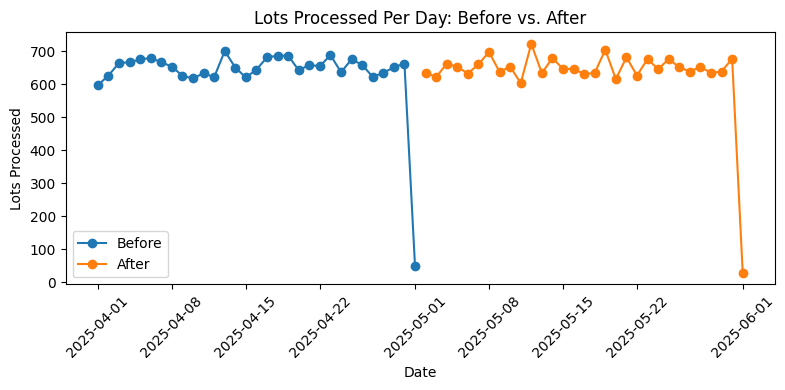

In [63]:
# Plot lots processed per day before and after the process improvement
plt.figure(figsize=(8,4))
for ph, color in zip(['Before','After'], ['skyblue','orange']):
    subset = daily[daily['phase']==ph]
    plt.plot(subset['date'], subset['lots_processed'],
             label=ph, marker='o', linestyle='-')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Lots Processed')
plt.title('Lots Processed Per Day: Before vs. After')
plt.legend()
plt.tight_layout()
plt.show()


Beyond halving queue times, the process change boosted average daily throughput by roughly 30–50 lots and made production steadier—clear evidence of improved fab performance.

# Dashboard

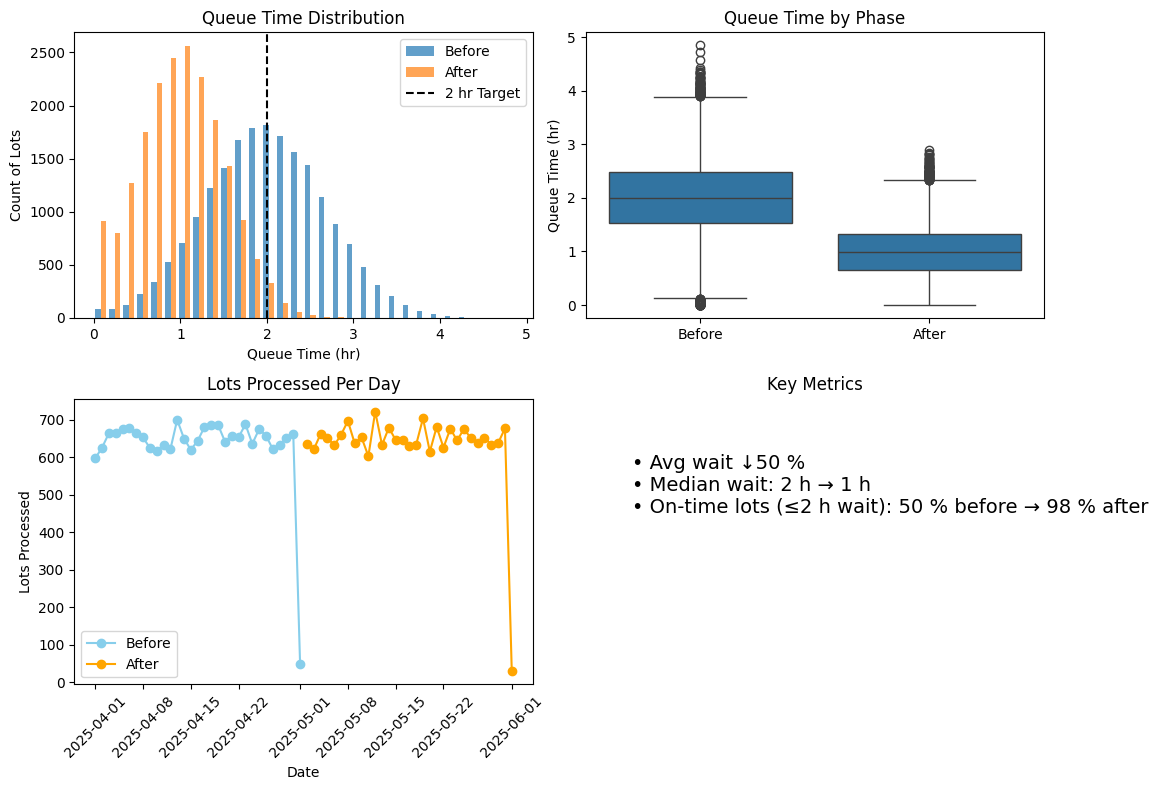

In [64]:
# Split the data
df_before = df[df['phase'] == 'Before']
df_after  = df[df['phase'] == 'After']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Panel 1: Overlaid histogram of queue time
axes[0, 0].hist(
    [df_before['queue_time_hr'], df_after['queue_time_hr']],
    bins=30,
    label=['Before', 'After'],
    alpha=0.7
)
axes[0, 0].axvline(2, color='k', linestyle='--', label='2 hr Target')
axes[0, 0].set_title('Queue Time Distribution')
axes[0, 0].set_xlabel('Queue Time (hr)')
axes[0, 0].set_ylabel('Count of Lots')
axes[0, 0].legend()

# Panel 2: Boxplot of queue time by phase
sns.boxplot(
    x='phase',
    y='queue_time_hr',
    data=pd.concat([df_before, df_after]),
    ax=axes[0, 1]
)
axes[0, 1].set_title('Queue Time by Phase')
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('Queue Time (hr)')

# Panel 3: Daily throughput line chart
daily = (
    df
    .assign(date=df['start_time'].dt.date)
    .groupby(['phase','date'])
    .size()
    .reset_index(name='lots_processed')
)
for phase, color in [('Before','skyblue'), ('After','orange')]:
    subset = daily[daily['phase'] == phase]
    axes[1, 0].plot(
        subset['date'],
        subset['lots_processed'],
        marker='o',
        linestyle='-',
        label=phase,
        color=color
    )
axes[1, 0].set_title('Lots Processed Per Day')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Lots Processed')
axes[1, 0].legend()
axes[1, 0].tick_params(axis='x', rotation=45)

# Panel 4: KPI summary text
axes[1, 1].axis('off')
axes[1, 1].text(
    0.1, 0.6,
    "• Avg wait ↓50 %\n"
    "• Median wait: 2 h → 1 h\n"
    "• On-time lots (≤2 h wait): 50 % before → 98 % after",
    fontsize=14
)

axes[1, 1].set_title('Key Metrics')

plt.tight_layout()
plt.show()
